In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắn index
df = pd.read_csv('/content/drive/MyDrive/Project_dataset/HPG.csv')
df=df.reset_index()['Price']
df

0       14831.7
1       15284.1
2       15560.7
3       15409.8
4       15233.9
         ...   
1246    21350.0
1247    21200.0
1248    21400.0
1249    21600.0
1250    21650.0
Name: Price, Length: 1251, dtype: float64

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 13s 302ms/step - loss: 0.0599 - val_loss: 0.0039
Epoch 2/100
15/15 [==============================] - 3s 190ms/step - loss: 0.0057 - val_loss: 0.0075
Epoch 3/100
15/15 [==============================] - 5s 297ms/step - loss: 0.0037 - val_loss: 0.0151
Epoch 4/100
15/15 [==============================] - 3s 181ms/step - loss: 0.0021 - val_loss: 0.0152
Epoch 5/100
15/15 [==============================] - 3s 175ms/step - loss: 0.0020 - val_loss: 0.0117
Epoch 6/100
15/15 [==============================] - 3s 183ms/step - loss: 0.0019 - val_loss: 0.0098
Epoch 7/100
15/15 [==============================] - 4s 271ms/step - loss: 0.0017 - val_loss: 0.0091
Epoch 8/100
15/15 [==============================] - 4s 242ms/step - loss: 0.0017 - val_loss: 0.0076
Epoch 9/100
15/15 [==============================] - 3s 193ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 10/100
15/15 [==============================] - 3s 193ms/step - loss: 0.0016 - val_l

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 83ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
train_size1 = int(0.8 * len(df))
test_size1 = int(0.1 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [13]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 2059.4931732102896
Testing RMSE: 6858.749038948812
Validation MAPE: 8.638583949548382
Testing MAPE: 27.842784314938225
Validation MAE: 1706.5241145833334
Testing MAE: 6066.57092141927


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=66
i=0
while(i<30):

    if(len(temp_input)>66):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.39925703]
67
1 day input [0.361479   0.35462669 0.35599715 0.37518364 0.37792457 0.37792457
 0.3806655  0.37518364 0.35325622 0.3806655  0.36833132 0.35599715
 0.34503344 0.35736761 0.35325622 0.35599715 0.35599715 0.36696086
 0.36421993 0.36696086 0.36696086 0.36696086 0.37244271 0.37518364
 0.38614735 0.38614735 0.37792457 0.36421993 0.36696086 0.3655904
 0.35736761 0.36284947 0.36833132 0.37107225 0.36696086 0.36696086
 0.36421993 0.36284947 0.37381318 0.39985199 0.39162921 0.39025874
 0.3806655  0.38477689 0.38888828 0.39437013 0.39162921 0.39299967
 0.40944524 0.40259292 0.39985199 0.39437013 0.39848153 0.39437013
 0.39711106 0.39162921 0.3806655  0.37792457 0.37518364 0.38477689
 0.38203596 0.37792457 0.38340642 0.38888828 0.39025874 0.39925703]
1 day output [[0.40202242]]
2 day input [0.35462669 0.35599715 0.37518364 0.37792457 0.37792457 0.3806655
 0.37518364 0.35325622 0.3806655  0.36833132 0.35599715 0.34503344
 0.35736761 0.35325622 0.35599715 0.35599715 0.36696086 0.3642

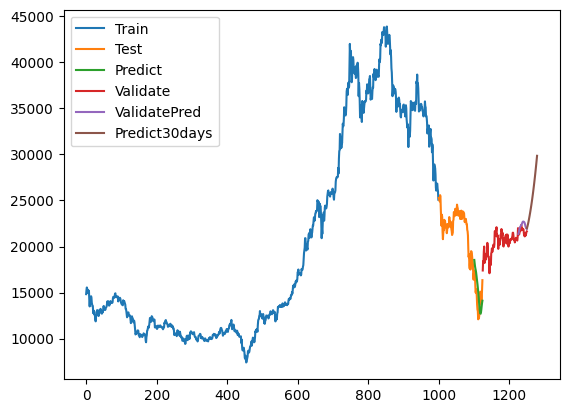

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()